<a href="https://colab.research.google.com/github/sayarghoshroy/Recurrent_NN_Modelling/blob/master/Moving_Average_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# RNN for auto-regressive model

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

In [0]:
# Moving Average Model

U = np.random.normal(0, 1, 5).tolist()
X_moving_avg = []

# Generating Samples

for generate in range(4000):
    value = 5 * U[-1] - (U[-2] + U[-3] + U[-4] + U[-5])
    X_moving_avg.append(value)
    U.append(np.random.normal(0, 1))

X_train = np.asarray(X_moving_avg[0: 2000])
X_test = np.asarray(X_moving_avg[2000: 4000])

In [0]:
scaler = MinMaxScaler(feature_range = (-1, 1))
train_normalized = scaler.fit_transform(X_train.reshape(-1, 1))
normalized_train_set = torch.FloatTensor(train_normalized).view(-1)

In [0]:
def make_sequence(input_sequence, window):
    sequence = []
    size = len(input_sequence)

    for index in range(size - window):
        train_sequence = input_sequence[index: index + window]
        train_label = input_sequence[index + window: index + window + 1]
        # predict the next item given a window size

        sequence.append((train_sequence, train_label))
    
    return sequence

In [0]:
train_X_y = make_sequence(normalized_train_set, 3)
test_X_y = make_sequence(normalized_train_set, 3)

In [0]:
class RNN_time_series(nn.Module):
    def __init__(self, input_size = 1, hidden_layer_size = 100, output_size = 1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers = 3)
        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))
        
    def forward(self, input_sequence):
        input_size = len(input_sequence)
        rnn_out, self.hidden_cell = self.lstm(input_sequence.view(input_size, 1, -1), self.hidden_cell)
        predicted = self.linear(rnn_out.view(input_size, -1))
        return predicted[-1]

In [0]:
model = RNN_time_series()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), 5 * 1e-2)

In [9]:
# training:
num_epochs = 20
losses = []

for index in tqdm(range(num_epochs)):
    error = 0
    for X, y in train_X_y:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(3, 1, model.hidden_layer_size),
                             torch.zeros(3, 1, model.hidden_layer_size))
        
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        loss.backward()
        optimizer.step()
        error += loss.item()
    losses.append(error / len(train_X_y))

100%|██████████| 20/20 [06:58<00:00, 20.94s/it]


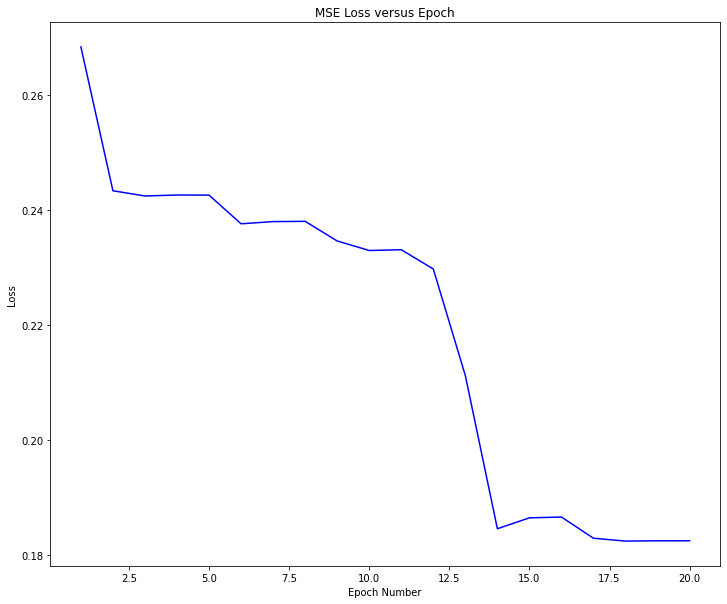

In [10]:
# plotting MSE loss versus Iteration Curve
vis = plt.figure(figsize = (12, 10))
fig = vis.add_subplot('111')

fig.set_title('MSE Loss versus Epoch')
fig.set_xlabel('Epoch Number')
fig.set_ylabel('Loss')

x = [index for index in range(1, len(losses)  + 1)]
fig.plot(x, losses, color = 'blue')
vis.show()

In [0]:
# getting into prediction mode
model.eval()

test_sequence = normalized_train_set[-3: ].tolist()

for index in range(2000):
    seq = torch.FloatTensor(test_sequence[-3: ])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_sequence.append(model(seq).item())

In [0]:
X_test_predicted = scaler.inverse_transform(np.asarray(test_sequence[3: ]).reshape(-1, 1)).reshape(2000, )
X_test_predicted = np.asarray(test_sequence[3: ]).reshape(2000, )

In [0]:
def R_squared(true, pred):
    means = np.array([np.mean(true) for elem in true])

    error_regr = np.power(np.linalg.norm(true - pred), 2)
    error_mean = np.power(np.linalg.norm(true - means), 2)

    return (1 - (error_regr / error_mean))

In [14]:
# Metrics:
test_size = 2000
MSE = np.linalg.norm(X_test_predicted - X_test) / test_size
MAE = np.sum(np.absolute(X_test_predicted - X_test)) / test_size
R2 = R_squared(X_test, X_test_predicted)

print("MSE: " + str(MSE))
print("MAE: " + str(MAE))
print("R-squared: " + str(R2))

MSE: 0.11645269161467944
MAE: 4.169944311614238
R-squared: -0.004852862596181895


In [0]:
# ^_^ Thank You